In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
#new_saver.save(sess, "../models/niger-current/model")

In [3]:
new_saver = tf.train.import_meta_graph('../models/january-super-sgd-finetune/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/january-super-sgd-finetune/'))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/january-super-sgd-finetune/model


In [4]:
# setup function to reproject coordinates
EPSG = CRS.WGS84
def convertCoords(xy, src='', targ=''):

    srcproj = osr.SpatialReference()
    srcproj.ImportFromEPSG(src)
    targproj = osr.SpatialReference()
    if isinstance(targ, str):
        targproj.ImportFromProj4(targ)
    else:
        targproj.ImportFromEPSG(targ)
    transform = osr.CoordinateTransformation(srcproj, targproj)

    pt = ogr.Geometry(ogr.wkbPoint)
    pt.AddPoint(xy[0], xy[1])
    pt.Transform(transform)
    return([pt.GetX(), pt.GetY()])

def bounding_box(point, x_offset_max = 140, y_offset_max = 140, expansion = 10):
    # LONG, LAT FOR SOME REASON
    tl = point
    
    if 102 <= tl[0] <= 109:
        epsg = 32648 if tl[1] > 0 else 32748
    if 96 <= tl[0] <= 102:
        epsg = 32647 if tl[1] > 0 else 32747
    if 90 <= tl[0] <= 96:
        epsg = 32646 if tl[1] > 0 else 32746
    if 84 <= tl[0] <= 90:
        epsg = 32645 if tl[1] > 0 else 32745
    if 78 <= tl[0] <= 84:
        epsg = 32644 if tl[1] > 0 else 32744
    if 72 <= tl[0] <= 78:
        epsg = 32643 if tl[1] > 0 else 32743
    if 66 <= tl[0] <= 72:
        epsg = 32642 if tl[1] > 0 else 32742
    if 60 <= tl[0] <= 66:
        epsg = 32641 if tl[1] > 0 else 32741
    if 54 <= tl[0] <= 60:
        epsg = 32640 if tl[1] > 0 else 32740
    if 48 <= tl[0] <= 54:
        epsg = 32639 if tl[1] > 0 else 32739
    if 42 <= tl[0] <= 48:
        epsg = 32638 if tl[1] > 0 else 32738
    if 36 <= tl[0] <= 42:
        epsg = 32637 if tl[1] > 0 else 32737
    if 30 <= tl[0] <= 36:
        epsg = 32636 if tl[1] > 0 else 32736
    if 24 <= tl[0] <= 30:
        epsg = 32635 if tl[1] > 0 else 32735
    if 18 <= tl[0] <= 24:
        epsg = 32634 if tl[1] > 0 else 32734
    if 12 <= tl[0] <= 18:
        epsg = 32633 if tl[1] > 0 else 32733
    if 6 <= tl[0] <= 12:
        epsg = 32632 if tl[1] > 0 else 32732
    if 0 <= tl[0] <= 6:
        epsg = 32631 if tl[1] > 0 else 32731
    if -6 <= tl[0] <= 0:
        epsg = 32630 if tl[1] > 0 else 32730
    if -12 <= tl[0] <= -6:
        epsg = 32629 if tl[1] > 0 else 32729
    if -18 <= tl[0] <= -12:
        epsg = 32628 if tl[1] > 0 else 32728
    if -24 <= tl[0] <= -18:
        epsg = 32627 if tl[1] > 0 else 32727
    if -30 <= tl[0] <= -24:
        epsg = 32626 if tl[1] > 0 else 32726
    if -36 <= tl[0] <= -30:
        epsg = 32625 if tl[1] > 0 else 32725
    if -42 <= tl[0] <= -36:
        epsg = 32624 if tl[1] > 0 else 32724
    if -48 <= tl[0] <= -42:
        epsg = 32623 if tl[1] > 0 else 32723
    if -78 <= tl[0] <= -72:
        epsg = 32618 if tl[1] > 0 else 32718
    if -84 <= tl[0] <= -78:
        epsg = 32617 if tl[1] > 0 else 32717
    if -90 <= tl[0] <= -84:
        epsg = 32616 if tl[1] > 0 else 32716
    if -96 <= tl[0] <= -90:
        epsg = 32615 if tl[1] > 0 else 32715
    if -102 <= tl[0] <= -96:
        epsg = 32614 if tl[1] > 0 else 32714
    if -108 <= tl[0] <= -102:
        epsg = 32613 if tl[1] > 0 else 32713
    if -114 <= tl[0] <= -108:
        epsg = 32612 if tl[1] > 0 else 32712
    if -120 <= tl[0] <= -114:
        epsg = 32611 if tl[1] > 0 else 32711
    if -126 <= tl[0] <= -120:
        epsg = 32610 if tl[1] > 0 else 32710
        
        

    tl = convertCoords(tl, 4326, epsg)
    
    br = (tl[0], tl[1])
    tl = ((tl[0] + (x_offset_max)), (tl[1] + (y_offset_max )))
    distance1 = tl[0] - br[0]
    distance2 = tl[1] - br[1]
    #EXPANSION = (expansion - np.mean([distance1, distance2]))/2 # should this be 155 or 160?
    
    br = [a - expansion for a in br]
    tl = [a + expansion for a in tl]
    
    after = [b - a for a,b in zip(br, tl)]
    print(after)
    #br = (br[0] + 20, br[1] + 20)
    #tl = (tl[0] - 20, tl[1] - 20)
    br = convertCoords(br, epsg, 4326)
    tl = convertCoords(tl, epsg, 4326)
    
    min_x = tl[0] # original X offset - 10 meters
    max_x = br[0] # original X offset + 10*GRID_SIZE meters
    
    min_y = tl[1] # original Y offset - 10 meters
    max_y = br[1] # original Y offset + 10 meters + 140 meters
    # (min_x, min_y), (max_x, max_y)
    # (bl, tr)
    return [(min_x, min_y), (max_x, max_y)]

81 64 72 72 289


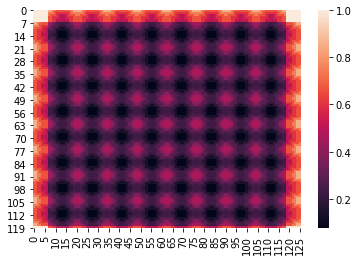

In [5]:
arr = np.array([[1, 1, 2, 2, 3, 3, 3],
                [1, 1, 2, 3, 3, 3, 3],
                [2, 2, 2, 3, 4, 4, 4],
                [2, 3, 3, 3, 4, 5, 6],
                [3, 3, 4, 4, 4, 5, 6],
                [3, 3, 4, 4, 5, 5, 6], 
                [3, 3, 4, 4, 6, 6, 6]])

#arr = np.array(
#      [[0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 1, 1, 1, 1, 1],
#       [0, 1, 2, 2, 2, 2, 2],
#       [0, 1, 2, 3, 3, 3, 3],
#       [0, 1, 2, 3, 4, 4, 4],
#       [0, 1, 2, 3, 4, 5, 5], 
#       [0, 1, 2, 3, 4, 5, 6]])

arr = arr / 6


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums
sns.heatmap(normal)



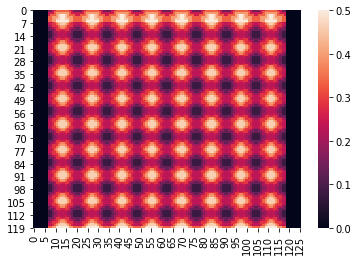

In [6]:
sns.heatmap(right_filter)

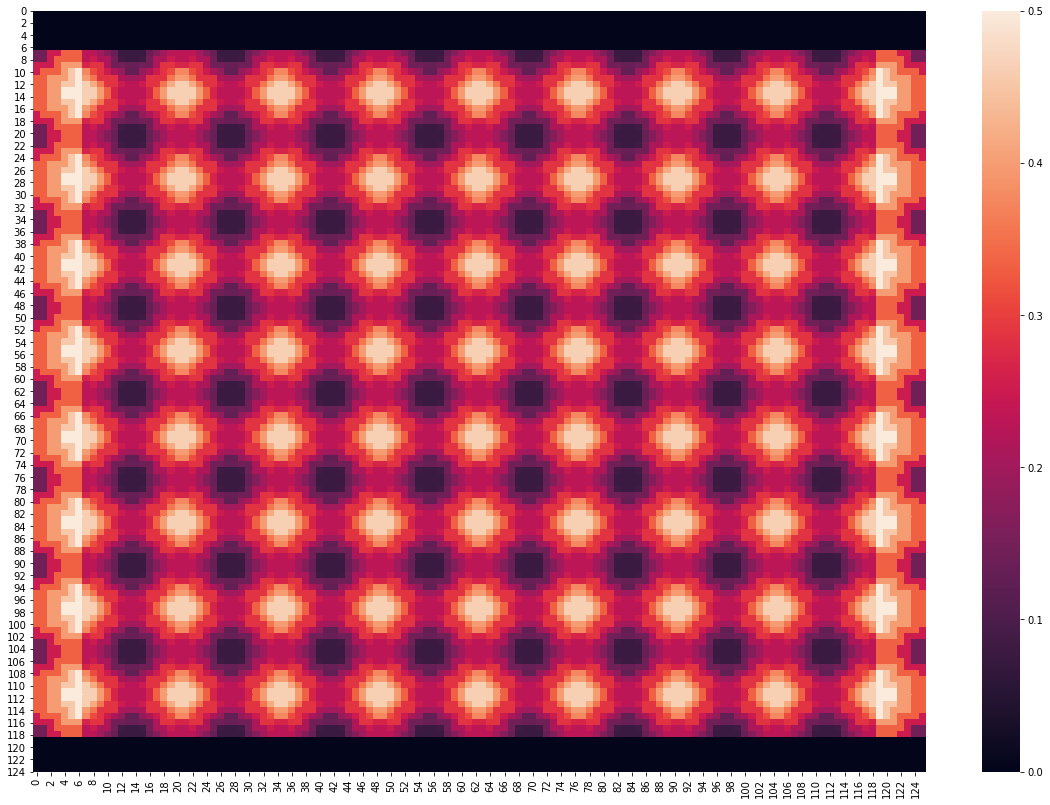

In [7]:
plt.figure(figsize=(20, 14))
sns.heatmap(up_filter)

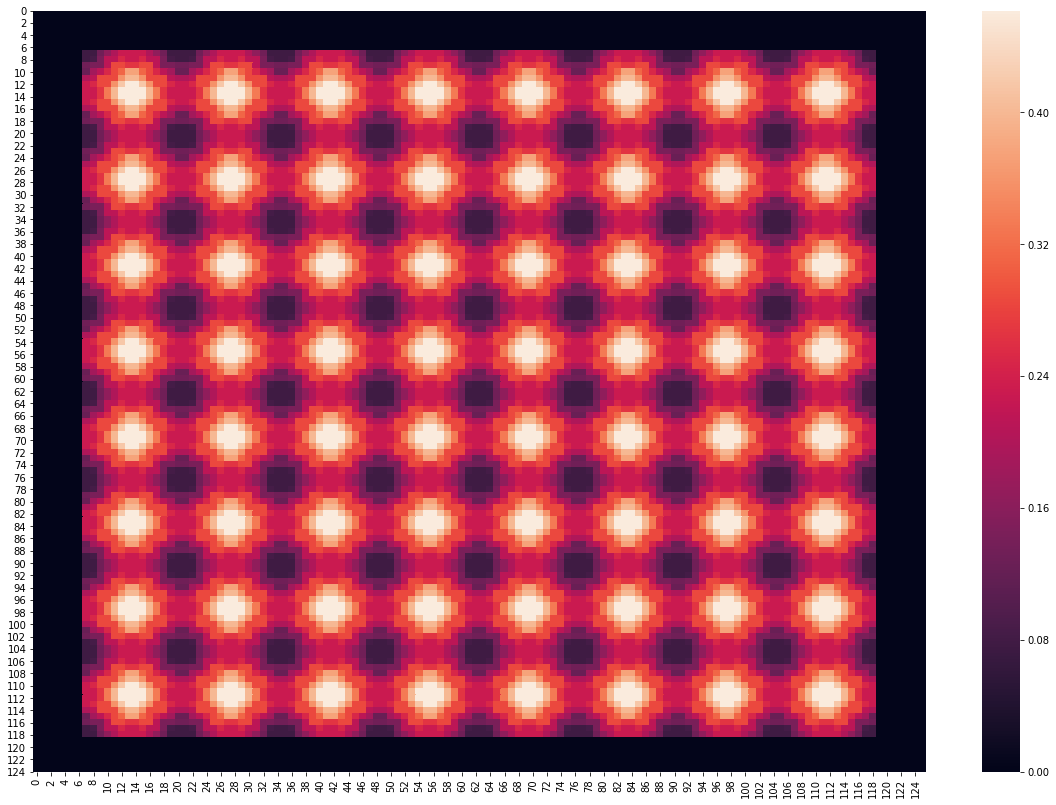

In [8]:
plt.figure(figsize=(20, 14))
sns.heatmap(upright[:, :])

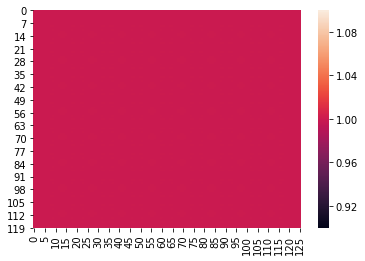

In [9]:
sum_filter = (upright + normal+right_filter + up_filter)# + right_filter + up_filter)
sns.heatmap(sum_filter)

In [10]:
np.tile(np.array(24), (24, 1)).shape

(24, 1)

In [11]:
# December 10-11 model, validated-size, filled in by train-l2a-dec
min_all = [0.019788351394236087,
 0.0376599433645606,
 0.022249658703804017,
 0.09112316101789475,
 0.06029978767037392,
 0.08587831154465678,
 0.09322187490761281,
 0.10038416087627411,
 0.09066671133041382,
 0.04962744191288948,
 0.0,
 0.010814227256923915,
 -0.020943850725889203,
 0.008634393354877836]

max_all = [0.17124534726142882,
 0.2569628745317458,
 0.3763543248176573,
 0.4688883873820304,
 0.422776158452034,
 0.44434353709220886,
 0.4722869098186493,
 0.4879453480243683,
 0.6069133794307708,
 0.5277097404003142,
 0.36966854333877563,
 0.69947146654129,
 0.39734595388174054,
 0.6361596417427062]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            #np.save(output_folder + str(base_id+x_offset*9+y_offset+1), subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images
            #np.save(output_folder + str(base_id+x_offset*8+y_offset+1), subs)



def load_and_predict_folder(y_col, folder, overlap_filter = upright, normal_filter = normal):
    #pred_files = ["../data/oregon/" + str(y_col) + "/" + str(folder) + "/" + str(x) + ".npy" for x in range(1, TOTAL+1)]
    pred_files = ["../data/usa/" + str(y_col) + "/" + str(folder) + ".npy"]
    #pred_x = np.empty((0, 24, 16, 16, 14))
    pred_x = []

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        #if x.shape[0] < 24:
        #    padding = np.tile(x[-1, :, :, :], (24-x.shape[0], 1, 1, 1))
        #    x = np.concatenate((x, padding), axis = 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, -1, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)
        
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        mins, maxs = (np.min(pred_x[:, :, :, :, x]), np.max(pred_x[:, :, :, :, x]))
        
    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        #lengths = np.array(24).tile((batch_x.shape[0], 1))
        lengths = np.tile(np.array(24), (batch_x.shape[0], 1))
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
        
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
        
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright
        
    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    #stacked = stacked / sum_filter
    return stacked

In [12]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    

In [13]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")

In [14]:
x = np.load("../data/usa/0/0.npy")

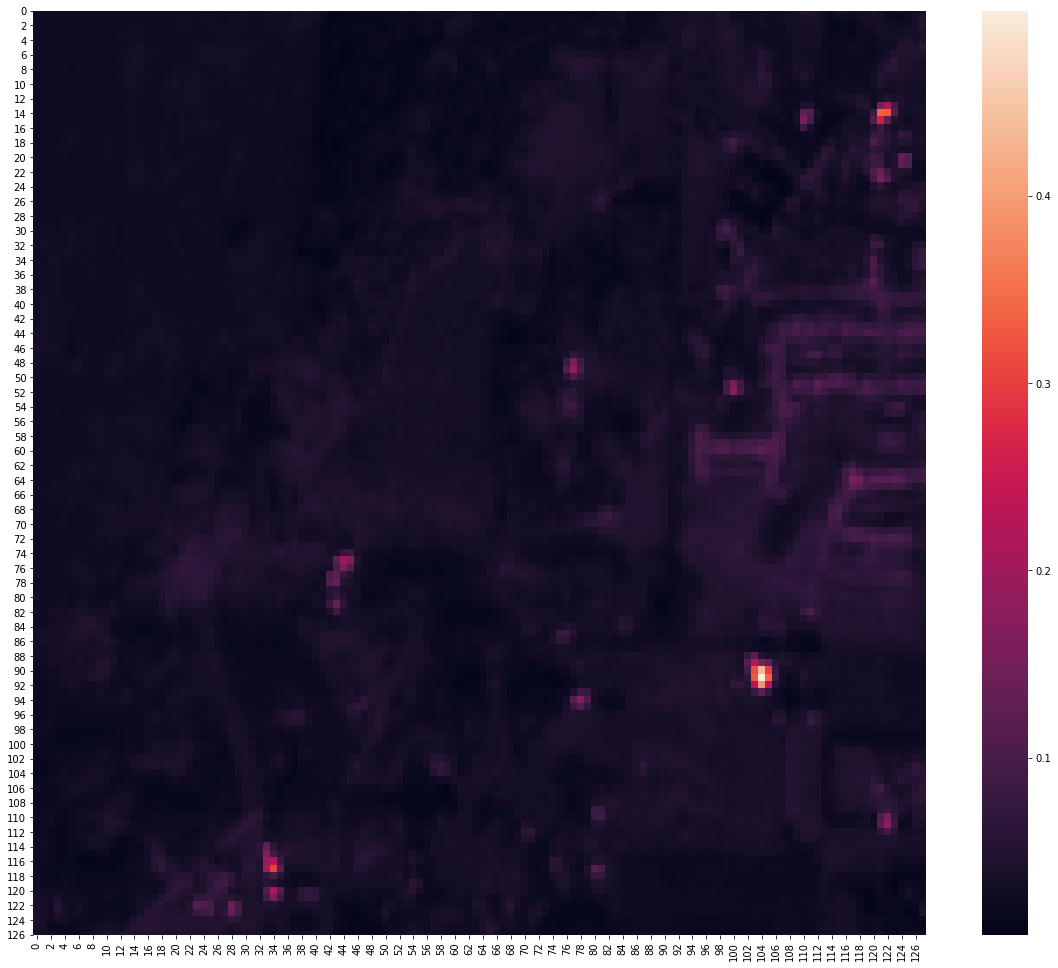

In [40]:
plt.figure(figsize=(20, 17))
sns.heatmap(x[21, :, :, 0])

In [41]:
from time import sleep
all_preds = []
for row in tnrange(0,1):
    pred_i = [load_and_predict_folder(row, col) for col in range(0, 3)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(20)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked, overalpped, up, right = load_and_predict_folder(0, 0)

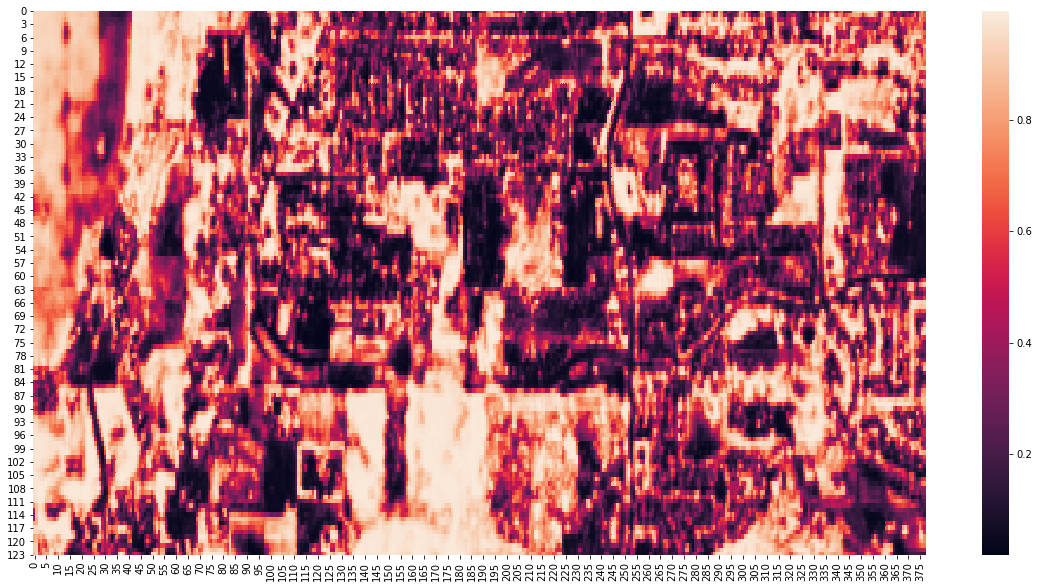

In [43]:
stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 10))
sns.heatmap(stacked)
#plt.savefig('ghana.png', dpi = 300)

In [44]:
thresh = 0.7 # .4, .44 for makueni, 65, 75 for kochi
thresh_p = 0.8

for window_x in range(2, stacked.shape[0]-2, 1):
    for window_y in range(2, stacked.shape[1]-2, 1):
        l, r, u, d =  False, False, False, False
        cur_window = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
        hor_vert_neighbors = False
        if (cur_window[2, 2] > thresh and
            cur_window[2, 2] < thresh_p):
            if cur_window[3, 2] > thresh and cur_window[4, 2] < thresh:
                hor_vert_neighbors = True
                r = True
            if cur_window[1, 2] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                l = True
            if cur_window[2, 3] > thresh and cur_window[2, 4] < thresh:
                hor_vert_neighbors = True
                d = True
            if cur_window[2, 1] > thresh and cur_window[2, 0] < thresh:
                hor_vert_neighbors = True
                u = True
        passes = False
        if r and not l:
            passes = True
        if l and not r:
            passes = True
        if d and not u:
            passes = True
        if u and not d:
            passes = True
        
        if passes:
            if r:
                if cur_window[1, 1] < thresh and cur_window[1, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
            
            if l:
                if cur_window[3, 1] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if u:
                if cur_window[1, 3] < thresh and cur_window[3, 3] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            if d:
                if cur_window[1, 1] < thresh and cur_window[3, 1] < thresh:
                    print("Adding a tree with: {}".format(cur_window[2, 2]))
                    stacked[window_x, window_y] = (thresh_p + 0.01)
                
            #n_offenders = 0
                
                #print(cur_window)

Adding a tree with: 0.7021400531133015
Adding a tree with: 0.7643652439117432
Adding a tree with: 0.762263149023056
Adding a tree with: 0.7360547383626301
Adding a tree with: 0.7285726865132649
Adding a tree with: 0.746221661567688
Adding a tree with: 0.7306369245052338
Adding a tree with: 0.7777289152145386
Adding a tree with: 0.7770309209823609
Adding a tree with: 0.81
Adding a tree with: 0.7114159703254701
Adding a tree with: 0.81
Adding a tree with: 0.798098236322403
Adding a tree with: 0.7902766466140747
Adding a tree with: 0.7672359228134156
Adding a tree with: 0.7458324432373047
Adding a tree with: 0.7970847090085347
Adding a tree with: 0.738701506094499
Adding a tree with: 0.7802275816599527
Adding a tree with: 0.7416316270828246
Adding a tree with: 0.7747177183628082
Adding a tree with: 0.7296364545822145
Adding a tree with: 0.7138581871986389
Adding a tree with: 0.780009318481792
Adding a tree with: 0.7562007687308571
Adding a tree with: 0.81
Adding a tree with: 0.74632505395

Adding a tree with: 0.7318432927131652
Adding a tree with: 0.7068766554196675
Adding a tree with: 0.7092624902725219
Adding a tree with: 0.81
Adding a tree with: 0.7358699015208653
Adding a tree with: 0.7785672247409821
Adding a tree with: 0.81
Adding a tree with: 0.7337454994519552
Adding a tree with: 0.7317284686224801
Adding a tree with: 0.7332363724708557
Adding a tree with: 0.7465499937534332
Adding a tree with: 0.7103117605050404
Adding a tree with: 0.7712577856503999
Adding a tree with: 0.7391715462391194
Adding a tree with: 0.7204545949186598
Adding a tree with: 0.7905004918575287
Adding a tree with: 0.7703933173959905
Adding a tree with: 0.7757814049720765
Adding a tree with: 0.7465767860412598
Adding a tree with: 0.7569080889225007
Adding a tree with: 0.7155144115289052
Adding a tree with: 0.81
Adding a tree with: 0.7789574265480042
Adding a tree with: 0.7468109864455001
Adding a tree with: 0.7142005562782286
Adding a tree with: 0.81
Adding a tree with: 0.7595269359075106
Add

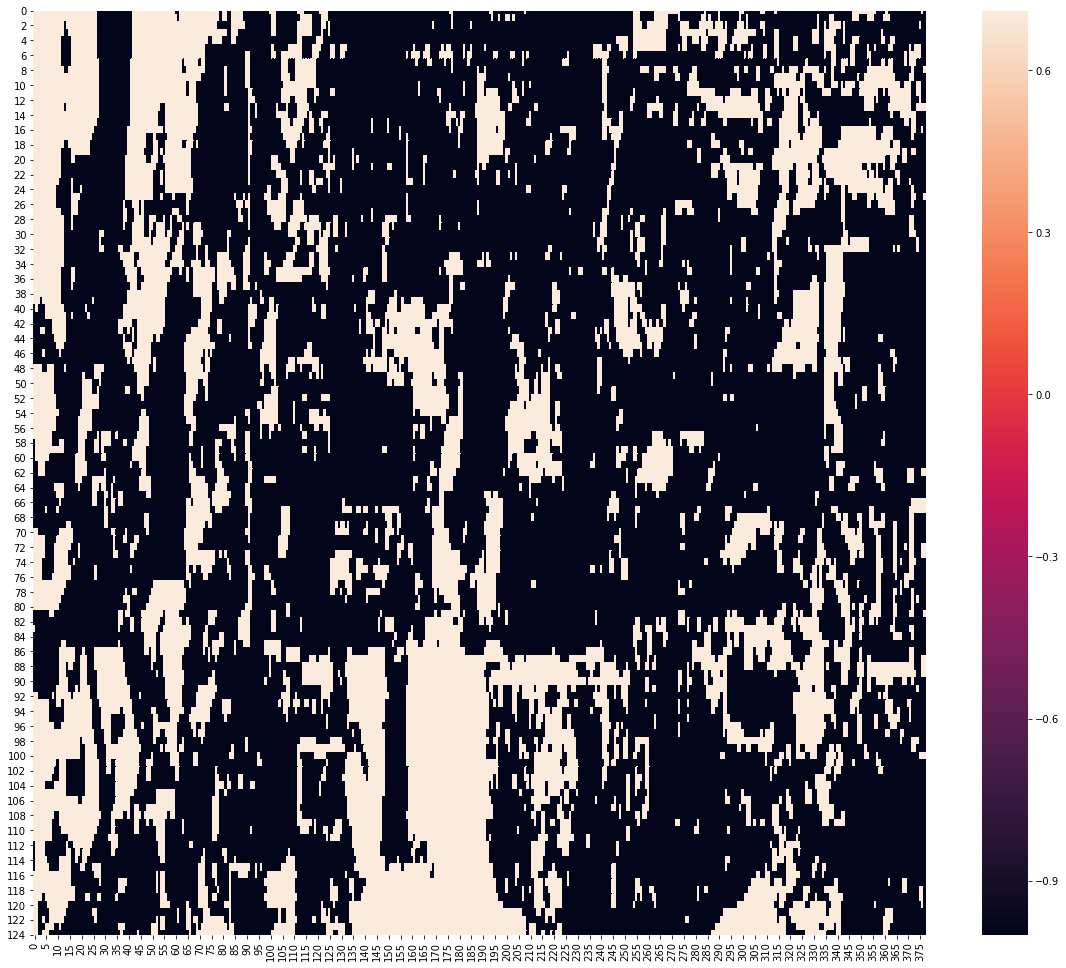

In [45]:
#stacked = np.concatenate(all_preds, axis = 0)
plt.figure(figsize=(20, 17))
stacked[np.where(stacked > thresh_p)] = 1.
stacked[np.where(stacked < thresh_p)] = -1
stacked[np.where(stacked == 1.0)] = 0.71
#stacked[np.where(np.logical_and(np.greater_equal(stacked, 0.3), np.greater_equal(0.4, stacked)))] = 0.5
sns.heatmap(stacked)
#plt.savefig('ghana2.png', dpi = 300)

In [46]:
#coords = (13.540810, 38.177220) # tigray
#coords = (-1.817109, 37.477563) # makueni-2
#coords = (-2.575694, 37.949516) # makueni-3
#coords = (-2.561161, 38.096274) # makueni
#coords = (9.259359, -0.833750) # ghana
#coords = (-1.515869, 29.952997) # rwanda
#coords = (13.18158333, 2.47805556) # niger - koure salima
#coords = (13.316919, 2.581680) # niger
#coords = (10.596, 14.2722) # cameroon
#coords = (18.232495, -92.134215) # campeche
#coords = (14.231732, -89.418679) # el salvador
#coords = (-11.044091, 33.818034) # malawi
#coords = (10.385811, -1.764760) # sisala east, ghana
#coords = (10.390084, -0.846330) # west mamprusi, ghana
#coords = (10.097017, -2.439068) #uppere west
#coords = (7.398111, -1.269223) # cocoa
#coords = (7.702058, -0.709011) # brong ahafo bono east
#coords = (-20.147326, -40.837780) # Esperito santo, BR
#coords = (24.070469, 81.606926) # sidhi, india
#coords = (-22.559943, -44.186629) # Vale do Paraiba, Brazil
#coords = (-20.147320, -40.837770) # ESPERITO SANTO BR 2
coords = (44.865106, -123.093435) # salem, oregon
#coords = (6.622101, -0.704616) # kwahu
#coords = (6.518909, -0.826008) # kwahu-large
#coords = (-6.352580, 106.677072) # jakarta
#coords = (6.167177, -75.693226) # medellin, colombia
#coords = (-1.648663, 30.112521) #rwanda
#coords = (11.574298, -12.492513) # guinea
#coords = (5.765917, 14.791618) # baboua, CAF
#coords = (-18.960152, 47.469587) # madagascar
#coords = (9.909083, 76.253594) # Kochi, india
#coords = (16.032170, -90.144511) # Guatemala
#coords = (13.727334, -90.015579) # elsalvador imposible
#coords = (-11.749636, 27.586622) # Kafubu, DRC
#coords = (-6.272258, 36.679824) # Tanzania


coords = (coords[1], coords[0])

point = bounding_box(coords, (3*1260)+0, (1*1260)+0, expansion = 0) # -85, +135 el salv
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]

[3780.0, 1260.0]


In [47]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/usa.tif', 'w', driver = 'GTiff',
                           height = stacked.shape[1], width = stacked.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

In [52]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.7)
summed += 0.1

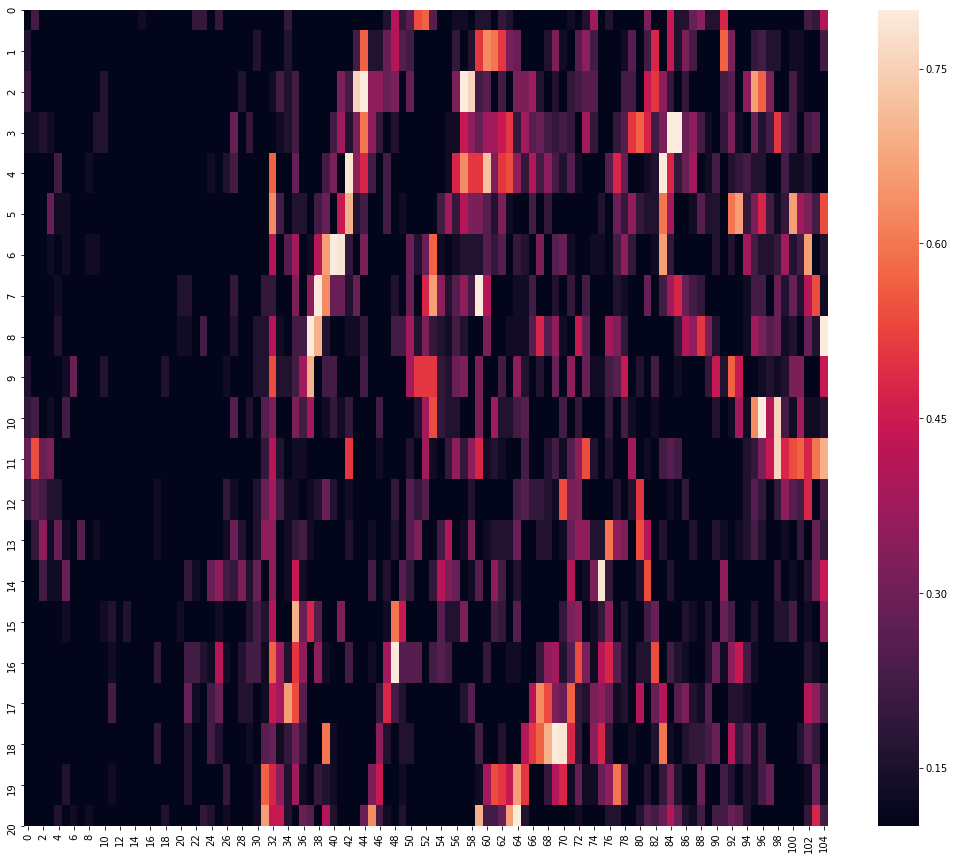

In [53]:
plt.figure(figsize=(18, 15))
sns.heatmap(summed)

In [54]:
np.min(summed)

0.1

In [55]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/tanzania1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()